In [1]:
from exceiver.models import Exceiver, ExceiverClassifier
from exceiver.datasets import ExceiverDataModule,ExceiverDataset
from scipy import sparse as sp
import scanpy as sc 
import pandas as pd
from tqdm import tqdm
from pathlib import  Path
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler
import torch
import joblib
import anndata as ad
import numpy as np

## Preprocessing

In [ ]:
adata = sc.read_csv("datasets/Guo/GSE99254.tsv",delimiter="\t").T
if not sp.issparse(adata.X):
    adata.X  = sp.csr_matrix(adata.X)
adata.obs_names_make_unique()
adata.var_names_make_unique()
import pandas as pd
from sklearn.preprocessing import LabelEncoder
subtype = pd.read_csv("/scratch/saigum/exceiver/datasets/Guo/subtype.ann",delimiter="\t").set_index("UniqueCell_ID ")
subtype["cluster_no"] = LabelEncoder().fit_transform(subtype["sampleType"])
adata.obs["subtype"] = subtype.loc[adata.obs_names]["cluster_no"]
adata.write_h5ad(filename="datasets/Guo/GSE99254.h5ad")

## Collect Embeddings

In [3]:

batch_size=2
data_path = Path("/scratch/saigum/exceiver/processed/guo")
dm = ExceiverDataModule(data_path=data_path, classify="subtype", batch_size=64, num_workers=0)
dm.prepare_data()
dm.setup(stage='fit')
val_dataset = ExceiverDataset(dm.val_adata.X, classes=dm.val_classes, scaler=dm.val_scaler, n_mask=dm.n_mask, batch_size=batch_size, inference=True)
sampler = BatchSampler(SequentialSampler(val_dataset), batch_size=val_dataset.batch_size, drop_last=True)
dl = DataLoader(val_dataset, batch_size=None, batch_sampler=None, sampler=sampler, num_workers=0, pin_memory=True)
gpu = "cuda:1"


n masked genes: 386
train_adata shape: (8637, 18626)
val_adata shape: (3702, 18626)
preparing class labels for subtype


In [5]:
# model_path="pretrained_models/exceiver/pretrained_TS_exceiver.ckpt"
gpu="cuda:0"
model_path="/scratch/saigum/exceiver/guo_model/logs/lightning_logs/guo/checkpoints/epoch=214-step=57835.ckpt"
model = Exceiver.load_from_checkpoint(model_path)
_ = model.eval()
_ = model.to(gpu)


emb = []
for batch in tqdm(dl):
    with torch.no_grad():
        batch = [i.to(gpu) if i is not None else i for i in batch]
        gene_ids, gene_vals, mask_ids, mask_vals, key_padding_mask, classify = batch
        input_query = model.query_emb.repeat(len(gene_ids), 1, 1)
        latent, encoder_weights = model.encoder_attn_step(gene_ids, gene_vals, input_query, key_padding_mask)
        latent = model.process_self_attn(latent)
        emb.append(latent.reshape(batch_size, -1).cpu())

# Concatenate and save to disk
emb = torch.cat(emb).numpy()
joblib.dump(emb, f"/scratch/saigum/exceiver/emb.joblib")

# Covnvert to AnnData object


/scratch/saigum/exceiver/test/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
  0%|          | 0/1851 [00:00<?, ?it/s]

100%|██████████| 1851/1851 [00:10<00:00, 181.28it/s]


['/scratch/saigum/exceiver/emb.joblib']

In [6]:
emb = joblib.load("/scratch/saigum/exceiver/emb.joblib")
emb_adata = ad.AnnData(X=emb.copy(), obs=dm.val_adata.obs[:len(emb)], var=pd.DataFrame({"emb_dim": np.arange(emb.shape[1])}))

# Compute UMAP
sc.pp.pca(emb_adata)
print("Computed PCA.")
sc.pp.neighbors(emb_adata, use_rep="X_pca")
print("Computed neighborhood graph.")
sc.tl.umap(emb_adata)
print("Computed UMAP.")

# Save to disk
emb_adata.write_h5ad(f"/scratch/saigum/exceiver/emb.h5ad")
print("Saved AnnData object to disk.")

/scratch/saigum/exceiver/test/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Computed PCA.


/scratch/saigum/exceiver/test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/saigum/exceiver/test/lib/python3.13/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Computed neighborhood graph.
Computed UMAP.
Saved AnnData object to disk.


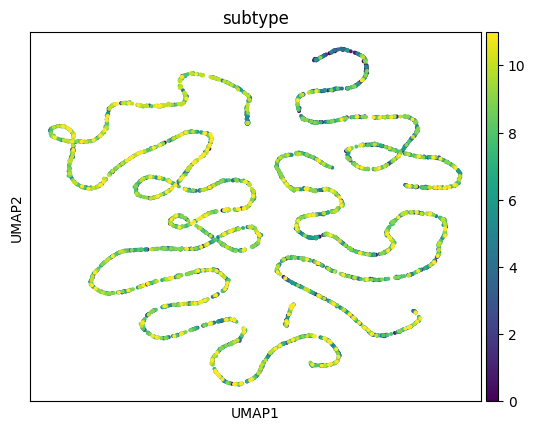

In [7]:
sc.pl.umap(emb_adata,color="subtype")

In [8]:
emb_adata.X

array([[-0.7424219 , -0.75316757,  1.3479313 , ...,  0.64001137,
        -1.4515548 , -0.19489966],
       [-0.71511567, -0.7630627 ,  1.372359  , ...,  0.6381283 ,
        -1.4419135 , -0.2076125 ],
       [-0.8003375 , -0.7290986 ,  1.2887548 , ...,  0.64415324,
        -1.4740599 , -0.16381414],
       ...,
       [-0.3140107 , -0.82816046,  1.5673009 , ...,  0.6167166 ,
        -1.3452346 , -0.3200087 ],
       [-0.61955005, -0.79122335,  1.4440744 , ...,  0.63206947,
        -1.4124466 , -0.24453747],
       [-0.5062387 , -0.81347126,  1.5062836 , ...,  0.62577045,
        -1.3839959 , -0.2778043 ]], shape=(3702, 256), dtype=float32)

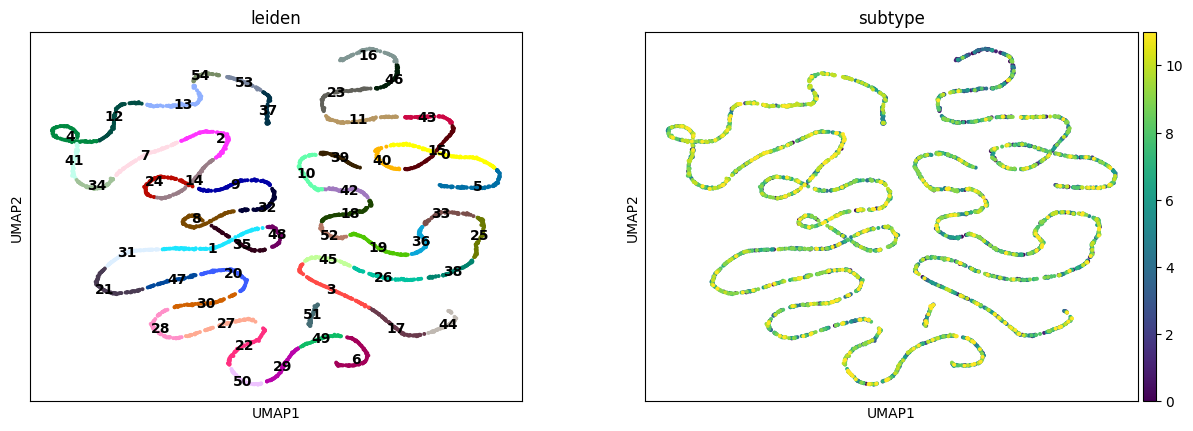

In [10]:
sc.tl.leiden(adata=emb_adata)
sc.pl.umap(
    emb_adata,
    color=["leiden","subtype"],
    legend_loc="on data",
)

In [12]:
print(f"Number of ground truth celltype clusters: {len(set(emb_adata.obs["subtype"]))}")

Number of ground truth celltype clusters: 12


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
kmeans=KMeans(n_clusters=8)

In [21]:
emb_adata.obs["kmeans"]=kmeans.fit_predict(emb_adata.X)

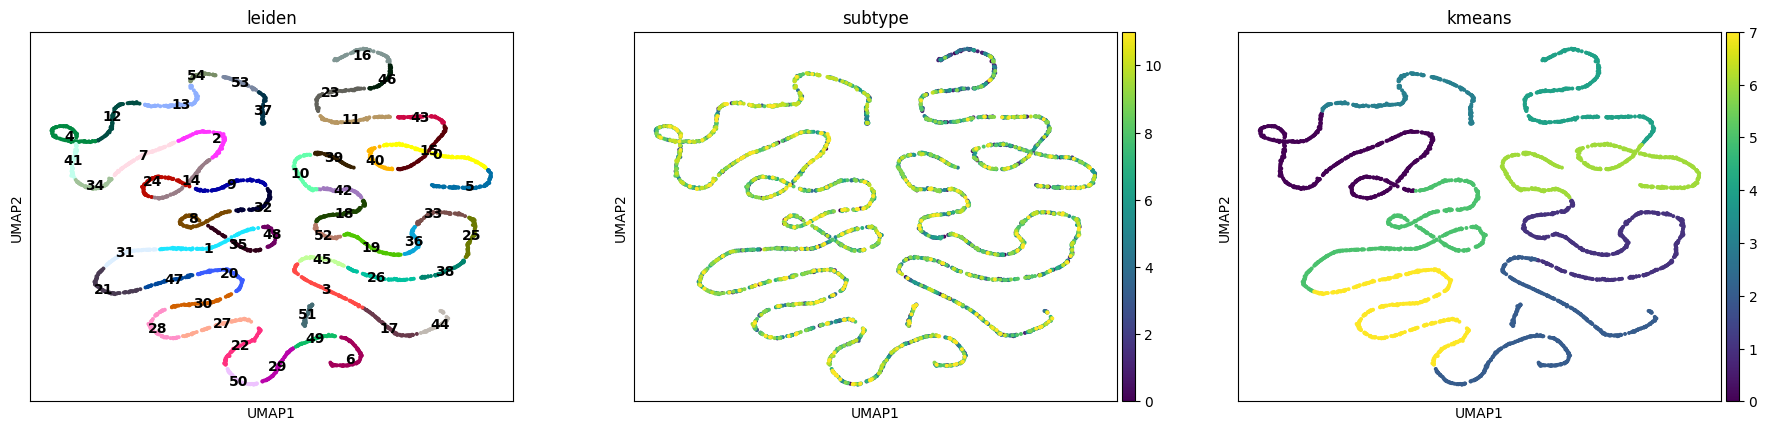

In [22]:
sc.pl.umap(
    emb_adata,
    color=["leiden","subtype","kmeans"],
    legend_loc="on data",
)

In [23]:
print(f"ARI score for kmeans assignment:{adjusted_rand_score(emb_adata.obs["subtype"],emb_adata.obs["kmeans"])}")

ARI score for kmeans assignment:0.010206930349566995


In [ ]:
fd = sc.read_h5ad("datasets/Guo/GSE99254.h5ad")
print(fd)
print(fd.X)